# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Посмотрим на размеры датасета

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Построим график распределения возростов**

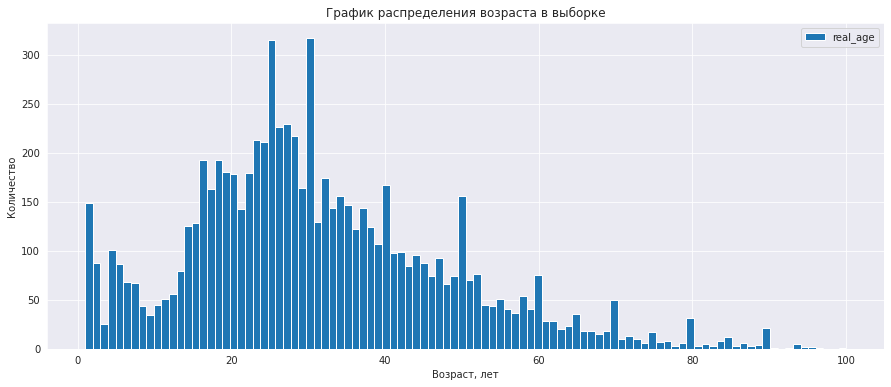

In [6]:
sns.set_style("dark")
labels.plot(kind='hist',figsize=(15,6),bins=100, grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

При помощи функции *next* получим *features* и *target*

In [7]:
features, target = next(train_gen_flow)

features.shape

(32, 224, 224, 3)

Выведем несколько фотографий

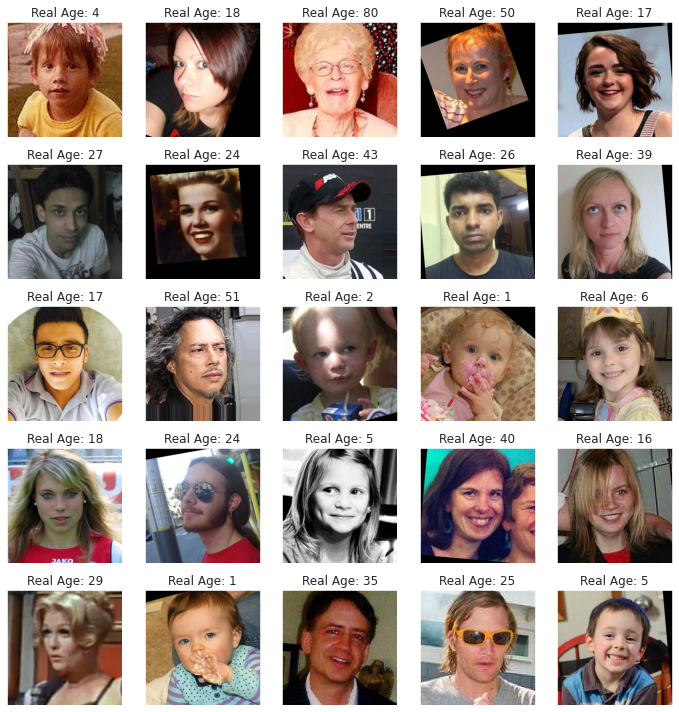

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(25):   
    image = Image.open('/datasets/faces/final_files/'+ labels.file_name[i])    
    fig.add_subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title('Real Age: ' + str(labels.real_age[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод по анализу данных:**

Имеем выборку с цветными фотографиями в количестве 7591 шт. и размером 224x224, разделённую на множество слоёв (батчей) по 32 тренировочных объекта в каждом. Данного количества фото должно быть достаточно для того, чтобы попробовать провести обучение нашей модели без заморозки основного слоя сети и избежать переобучения. Среди них есть повернутые изображения по горизонтали, поэтому мы должны добавить изображения с увеличенным вращением в тренировочную выборку.

Судя по графику распределения возраста, мы можем увидеть нормальное распределение данных со скосом вправо. Преобладающее большинство размеченных фотографий с возрастом от 18 до 40 лет. Соответственно наша модель будет давать более точные прогнозы на фотографиях людей в данной возрастной категории.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

**Код обучения модели**

```
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

**Результат работы модели**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 48s - loss: 225.8215 - mae: 10.7425 - val_loss: 539.6519 - val_mae: 18.1074
Epoch 2/10
356/356 - 39s - loss: 86.5509 - mae: 7.0360 - val_loss: 176.7419 - val_mae: 9.8806
Epoch 3/10
356/356 - 39s - loss: 60.7011 - mae: 5.9757 - val_loss: 90.1091 - val_mae: 6.9904
Epoch 4/10
356/356 - 39s - loss: 42.4638 - mae: 4.9818 - val_loss: 115.0342 - val_mae: 7.8475
Epoch 5/10
356/356 - 39s - loss: 33.0194 - mae: 4.4038 - val_loss: 82.4963 - val_mae: 6.9943
Epoch 6/10
356/356 - 39s - loss: 24.3472 - mae: 3.7964 - val_loss: 82.3902 - val_mae: 6.9203
Epoch 7/10
356/356 - 39s - loss: 22.1005 - mae: 3.5675 - val_loss: 94.7151 - val_mae: 7.6290
Epoch 8/10
356/356 - 39s - loss: 17.0033 - mae: 3.1449 - val_loss: 64.1044 - val_mae: 5.9616
Epoch 9/10
356/356 - 40s - loss: 13.6338 - mae: 2.8019 - val_loss: 66.6494 - val_mae: 6.0651
Epoch 10/10
356/356 - 39s - loss: 12.8133 - mae: 2.6965 - val_loss: 66.1317 - val_mae: 5.9302

119/119 - 10s - loss: 66.1317 - mae: 5.9302
Test MAE: 5.9302
```

## Анализ обученной модели

Для более точного обучения модели мы использовали специальные гиперпараметры. В тренировочную выборку (75%) были добавлены  фотографии с различными эффектами. А тестовыю выборку (25%) оставили без изменений.

В качестве основы за модель взяли уже предобученную нейросеть с архитектурой *ResNet50* и дополнительно обучили её на наших данных без замораживания. В выходном слое, для более точного обучения модели, использовали оптимизацию Adam c шагом обучения 0.0001, а в качестве функции потерь использовалась mean_squared_error.

С такими параметрами мы протестировали нашу модель на 10 эпохах. Лучший результат **MAE на тестовой выборке составил 5.93**, на 10 эпохе обучения. Таким образом мы достигли требуемой точности предсказания возраста нашей моделью и можем рекомендовать её к использованию.